In [1]:
import sqlite3
import pandas as pd
from contextlib import closing

In [2]:
'''
with closing(sqlite3.connect("../db/remote-simulations-sadegh.db")) as connection:
    with closing(connection.cursor()) as cursor:
        rows = cursor.execute("SELECT * from results").fetchall()
        print(rows)
'''
with closing(sqlite3.connect("../db/remote-simulations.db")) as connection:
    sql_query = pd.read_sql_query("SELECT * from results", connection)
    results = pd.DataFrame(sql_query)

results.head()

,execution_time,experiment_id,window_size,max_nodes,nodes_count,max_services,services_count,dataset,metric_name,metric_value,percentage,row_lower_bound,row_upper_bound,description,filtering_type,column_lower_bound,column_upper_bound
0,0.481855,1,1,5,2,5,2,inmates_enriched_10k,qualitative,0.337593,0.287329,0.2,1.0,column and row filtering with column_frac=0.2,mixed,0.8,0.8
1,0.231139,1,2,5,2,5,2,inmates_enriched_10k,qualitative,0.337593,0.287329,0.2,1.0,column and row filtering with column_frac=0.2,mixed,0.8,0.8
2,0.399061,1,1,5,3,5,2,inmates_enriched_10k,qualitative,0.477892,0.113511,0.2,1.0,column and row filtering with column_frac=0.2,mixed,0.8,0.8
3,0.466509,1,2,5,3,5,2,inmates_enriched_10k,qualitative,0.477892,0.113511,0.2,1.0,column and row filtering with column_frac=0.2,mixed,0.8,0.8
4,0.440229,1,3,5,3,5,2,inmates_enriched_10k,qualitative,0.477892,0.113511,0.2,1.0,column and row filtering with column_frac=0.2,mixed,0.8,0.8


## Aggregate results by one dimension

After filtering the results, they are grouped by `window_size` so that metric values with different `experiment_id` are averaged.

In [3]:
import operator
import functools

COMPARE_PROP = 'dataset'

prop_values = results[COMPARE_PROP].unique()
params = {
    'NODES_COUNT': 10,
    'MAX_SERVICES': 5,
    'SERVICES_COUNT': 5,
    'METRIC_NAME': 'qualitative',
    'ROW_LOWER_BOUND': 0.2,
    'ROW_UPPER_BOUND': 1,
    'COLUMN_LOWER_BOUND': 0.6,
    'COLUMN_UPPER_BOUND': 0.9,
    #'DATASET': 'inmates_enriched_10k',
    'DESCRIPTION': 'column and row filtering (assigning none to filtered)',
    'FILTERING_TYPE': 'mixed'
}

results_filters = [
    lambda df: df['max_services'] == params['MAX_SERVICES'],
    lambda df: df['services_count'] == params['SERVICES_COUNT'],
    lambda df: df['nodes_count'] == params['NODES_COUNT'],
    lambda df: df['metric_name'] == params['METRIC_NAME'],
    lambda df: df['row_lower_bound'] == params['ROW_LOWER_BOUND'],
    lambda df: df['row_upper_bound'] == params['ROW_UPPER_BOUND'],
    lambda df: df['column_lower_bound'] == params['COLUMN_LOWER_BOUND'],
    lambda df: df['column_upper_bound'] == params['COLUMN_UPPER_BOUND'],
    #lambda df: df['dataset'] == params['DATASET'],
    lambda df: df['description'] == params['DESCRIPTION'],
    lambda df: df['filtering_type'] == params['FILTERING_TYPE'],
]

def apply_filters_to_dataset(df, filters):
    compound_condition = functools.reduce(operator.and_, map(lambda filter: filter(df), filters))
    return df[compound_condition]

In [4]:
agg_results = {}
for prop_value in prop_values:
    filtered_results = apply_filters_to_dataset(results, results_filters + [lambda df: df[COMPARE_PROP] == prop_value]) \
        .groupby(['window_size'])[['metric_value']].mean() \
        .sort_values(by=['window_size', 'metric_value'])

    display(filtered_results)
    agg_results[prop_value] = filtered_results

,metric_value
window_size,
1,0.742035
2,0.703881
3,0.696312
4,0.687139
5,0.679269
6,0.681271
7,0.677187
8,0.670249


,metric_value
window_size,


,metric_value
window_size,


,metric_value
window_size,


,metric_value
window_size,


,metric_value
window_size,


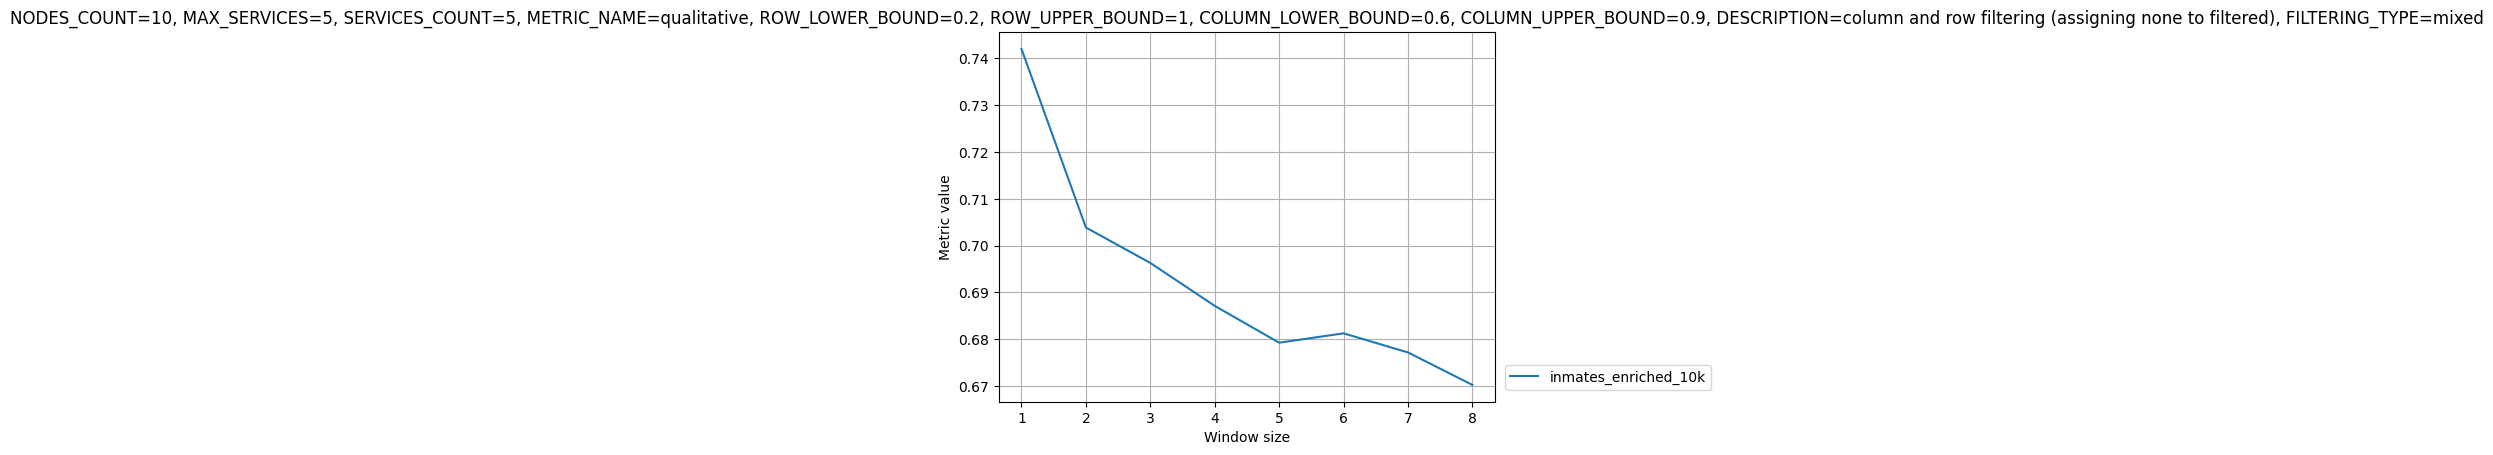

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# plt.figure(figsize=(10, 6))

for prop_value, dresults in agg_results.items():
    if len(dresults) == 0:
        continue
    ax.plot(dresults.index, dresults['metric_value'], label=prop_value)
    plt.xticks(dresults.index)

plot_title = ', '.join(map(lambda x: f'{x[0]}={x[1]}', params.items()))
ax.set_title(plot_title)
ax.set_xlabel('Window size')
ax.set_ylabel('Metric value')
ax.grid(True)
ax.legend(bbox_to_anchor=(1.02, 0.1), loc='upper left', borderaxespad=0)

plt.savefig(f'agg_{COMPARE_PROP}.svg', bbox_inches = "tight")
plt.show()

## All experiments by Dataset

Results for the same experiment id are not aggregated but have their own plot

In [5]:
results_map = {}
for prop_value in prop_values:
    results_map[prop_value] = {}
    filtered_results = apply_filters_to_dataset(results, results_filters + [lambda df: df[COMPARE_PROP] == prop_value])
    experiment_ids = filtered_results['experiment_id'].unique()
    for exp_id in experiment_ids:
        exp_id_results = filtered_results[filtered_results['experiment_id'] == exp_id][['window_size', 'metric_value']].drop_duplicates()
        results_map[prop_value][exp_id] = exp_id_results

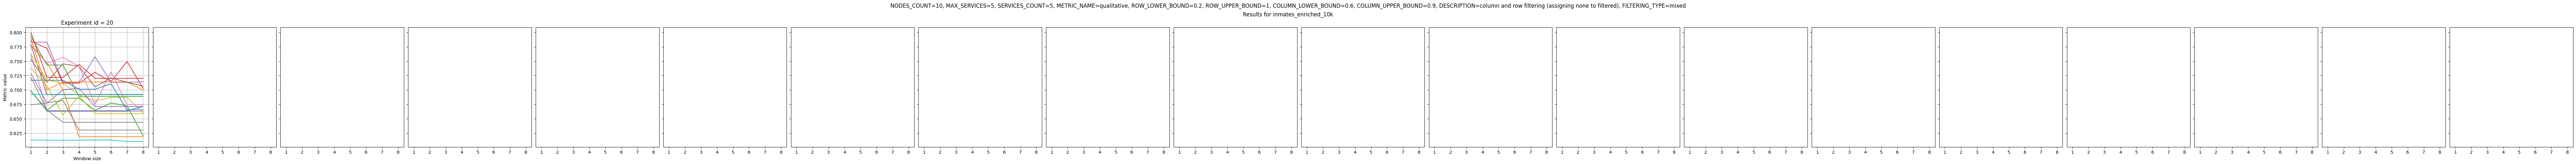

In [7]:
import matplotlib.pyplot as plt

results_map = {k:v for k, v in results_map.items() if len(v) > 0}
fig_width = max(len(exp_res) for exp_res in results_map.values()) * 4

results_count = len(results_map)
fig_height = results_count * 5
fig = plt.figure(figsize=(fig_width, fig_height), constrained_layout=True)

plot_title = ', '.join(map(lambda x: f'{x[0]}={x[1]}', params.items()))
fig.suptitle(plot_title)

subfigs = fig.subfigures(nrows=results_count, ncols=1, squeeze=False)

for i, (prop_value, results_per_prop) in enumerate(results_map.items()):
    subfig = subfigs.item(i)
    subfig.suptitle(f'Results for {prop_value}')

    axs = subfig.subplots(1, len(results_per_prop), sharex=True, sharey=True, squeeze=False)
    # plt.figure(figsize=(10, 6))
    for exp_index, (exp_id, exp_id_results) in enumerate(results_per_prop.items()):
        axs[0][exp_index].plot(exp_id_results['window_size'], exp_id_results['metric_value'])#, label=f'Experiment id = {exp_id}')
        axs[0][exp_index].set_xlabel('Window size')
        axs[0][exp_index].set_ylabel('Metric value')
        axs[0][exp_index].set_title(f'Experiment id = {exp_id}')
        axs[0][exp_index].grid(True)
        # axs[i][exp_id].legend()
        plt.xticks(exp_id_results['window_size'])

#fig.tight_layout()
plt.savefig(f'all_exp_{COMPARE_PROP}.svg', bbox_inches='tight')
plt.show()